In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy import signal
(x_train_c, y_train_c), (x_test_c, y_test_c) = keras.datasets.cifar10.load_data()
(x_train_m, y_train_m), (x_test_m, y_test_m) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
def submatrix(matrix, startRow, startCol, size):
  return matrix[(startRow):(startRow+size), (startCol):(startCol+size)]

In [90]:
def rotate_180(array, M, N, out):
    for i in range(M):
        for j in range(N):
            out[i, N-1-j] = array[M-1-i, j]

In [99]:
# Convololution function that takes either a single 2D or 3D image as input_matrix, and either a single kernel or 
# multiple kernels as input_kernels and returns a stack of feature maps equal to the amount of kernels.


def Convolution(input_matrix, input_kernels, mode):

# Checks whether a single kernel is used or multiple and changes the values used in the loops and output size accordingly.
  if (input_kernels.ndim == 3):
    kerneldepth = len(input_kernels)
    kernel_size = len(input_kernels[0])
  else:
    kerneldepth = 1
    kernel_size = len(input_kernels)

# Checks whether a 2D or 3D image is used and changes the values used in the loops and output size accordingly.
  if input_matrix.ndim == 2:
    depth = 1
    input_height, input_width = input_matrix.shape
  else:
    input_height, input_width, depth = input_matrix.shape

# Creates empty arrays for the outputs
  if mode == "valid":
    final_output_size = (kerneldepth, input_height - kernel_size + 1, input_width - kernel_size + 1)
    final_output = np.zeros(final_output_size)
    output_shape = (input_height - kernel_size + 1, input_width - kernel_size + 1)
    final_final_output = np.zeros(output_shape)
  if mode == "padded":
    final_output_size = (kerneldepth, input_height - kernel_size + 5, input_width - kernel_size + 5)
    final_output = np.zeros(final_output_size)
    output_shape = ((input_height - kernel_size) + 5, (input_width - kernel_size) + 5)
    final_final_output = np.zeros(output_shape)

# Loops over all the kernels and the depth of the image
  for j in range(kerneldepth):
    for i in range(depth):

      # Selects kernel and image to be used
      output = np.zeros(output_shape)
      kernel = input_kernels[j]
      if depth == 1:
        image = input_matrix
      else:
          image = input_matrix[:,:,i]
      Yimage, Ximage = image.shape
      if mode == "valid":

        new_image = np.zeros((input_height - kernel_size + 1, input_width - kernel_size + 1))
      if (mode == "padded"):

        output_image =  np.zeros((Yimage + 2, Ximage +2 ))
        new_image = np.zeros((Yimage + 2, Ximage + 2))
        for x in range(Ximage):
          for y in range(Yimage):
            new_image[x+1,y+1] = image[x,y]


      # Loops over the image, selecting a submatrix and multiplying it with the kernel, adding tha result to the new image
      for x in range(Ximage):
        for y in range(Yimage):
          if (x+kernel_size <= Ximage and y+kernel_size <= Yimage):
            if mode == "valid":
              sub = submatrix(image, x, y, kernel_size)
            if mode == "padded":
              sub = submatrix(new_image, x, y, kernel_size)
            mulitply = np.multiply(kernel,sub)
            add = np.sum(mulitply)
            if mode == "valid":
              new_image[x,y] = add
            if mode == "padded":
              output_image[x,y] = add
      # Adds the multiple multiple feature maps of the 3D images into a single feature map
      if mode == "valid":
        output += new_image
      if mode == "padded":
        output += output_image
    final_output[j] = output
  if (kerneldepth == 1):
    final_output = final_output[0]
  return final_output

In [5]:
# Relu activation function that takes a single feature map as input and ensures that all negative numbers become 0
# Returns the non-negative feature map

def relu(input_matrix):  
  output_shape = (input_matrix.shape[0], input_matrix.shape[1])
  output = np.zeros(output_shape)
  for i in range(input_matrix.shape[0]):
    output[i] = np.maximum(0,input_matrix[i])
  return output

In [6]:
# Normalise function that takes a single feature map as input and outputs the normalised feature map. 

def normalize(input_matrix):
  matrix = input_matrix
  matrix = matrix - matrix.mean()
  output = matrix/matrix.std()
  return output

In [7]:
# Fully-connected layer that takes a single matrix and output size as inputs, and outputs the weights and a final layer

def dense_layer(matrix, outputsize):
  flat = matrix.flatten()
  weights = np.zeros((flat.size, outputsize))
  layer = np.zeros((outputsize))

  # Gives all the weights a random value between 0.1 and 0.2
  for x in range(flat.size):
    for y in range(outputsize):
      weights[x,y] = random.uniform(0.1, 0.2)
  
  # Takes the dot product of the weights and the flattened input matrix
  for i in range(outputsize):
    layer[i] = np.dot(weights[:, i], flat)
    
  return weights, layer

In [8]:
# Softmax function that takes the output from the dense layer and returns the probabilities. 
# Converts the activation of the dense layer into probabilities 

def softmax(layer):
  soft = np.exp(layer)/sum(np.exp(layer))
  return soft

In [ ]:
# Code for one hot encoding, used by the the self-made convolutional neural network
# in order to calculate the derivative of the input of the final layer.

y_true = y_train_m
total_numbers = [0,1,2,3,4,5,6,7,8,9]

mapping = {}
for x in range(len(total_numbers)):
  mapping[total_numbers[x]] = x

one_hot_encode = []

for c in y_true:
  arr = list(np.zeros(len(total_numbers), dtype = int))
  arr[mapping[c]] = 1
  one_hot_encode.append(arr)

In [93]:
# Backpropagation function with the derivative of the filter in the next layer, the current layer inputs and current filter as inputs
# and outputs the derivative of the filters in the current layer and the derivative of the input of the current layer. 
# The derivative of the filters of the current layer is used to update the filters while the derivative of teh current layer input is used
# to backpropagate to the previous layer.

def backpropagation(derivative_filters_next_layer, current_layer_input, current_filter):

  # The kernel has to be rotated 180 degree to calculate the derivative of the current layer inputs, which is a padded version of the convolution operation.
  rotated_kernel = current_filter.copy()
  rotate_180(current_filter, 3, 3, rotated_kernel)
  
  # Uses the convolution operation to calculate the derivatives, one without padding for the derivative of the current layer and once padded for the derivative of the current input layer. 
  derivative_filters_current_layer = Convolution(current_layer_input, derivative_filters_next_layer, "valid")
  derivative_current_layer_input = Convolution(derivative_filters_next_layer, rotated_kernel, "padded")

  return derivative_filters_current_layer, derivative_current_layer_input

In [224]:
# Fully-connected layer that takes a single matrix and output size as inputs, and outputs the weights and a final layer

def dense_layer2(matrix, outputsize):
  flat = matrix.flatten()
  layer = np.zeros((outputsize))
  
  # Takes the dot product of the weights and the flattened input matrix
  for i in range(outputsize):
    layer[i] = np.dot(weights[:, i], flat)
    
  return layer

In [ ]:
# Stochastic gradient descent
# Random kernels
first_layer_kernels = np.random.randn(3,3)
second_layer_kernels = np.random.randn(3,3)

# Preset kernels
first_layer_kernels_vert = np.array([[-1,2,-1], [-1,2,-1],[-1,2,-1]])
second_layer_kernels_horz = np.array([[-1,-1,-1], [2,2,2],[-1,-1,-1]])

# Initalizing variables
learning_rate = 0.01
weight_der = np.zeros((576,10))
correct = 0
total_validation_correct = []
epochs = 20
train_batch = int(60000/ epochs)
test_batch = int(10000/ epochs)
total_correct = []

# Initializing weights
weights = np.zeros((576,10))
for x in range(576):
  for y in range(10):
    weights[x,y] = random.uniform(0.1,0.2)

# Start training convolutional neural network
for j in range(epochs):
  validation_correct = 0
  correct = 0
  for i in range(train_batch):
    # Forward pass for training data
    # For the sake of efficiency, the signal.correlate2d function is used here, but it does the exact same as our convolution function. 
    first_layer_output = signal.correlate2d(x_train_m[train_batch * j + i], first_layer_kernels_vert, "valid")
    first_relu_layer = relu(first_layer_output)
    first_norm_layer = normalize(first_relu_layer)

    second_layer_output = signal.correlate2d(first_norm_layer, second_layer_kernels_horz, "valid")
    second_relu_layer = relu(second_layer_output)
    second_norm_layer = normalize(second_relu_layer)

    dense_layer = dense_layer2(second_norm_layer, 10)
    soft_layer = softmax(dense_layer)
    der = soft_layer - one_hot_encode[train_batch * j + i]
    if soft_layer.argmax() == y_train_m[train_batch * j + i]:
      correct += 1

    # Backwards pass, updating weights
    weight_der = np.dot(second_norm_layer.reshape(-1,1), der.reshape(1,-1))
    weights -= learning_rate * weight_der
    input_derivatives = np.dot(weights, der.transpose())
    
    # Backpropagation of second layer, updating second layer filter
    reshaped_input_derivatives = input_derivatives.reshape(24,24)
    derivative_filters_current_layer, derivative_current_layer_input = backpropagation(reshaped_input_derivatives, first_norm_layer, second_layer_kernels)
    second_layer_kernels -= learning_rate * derivative_filters_current_layer

    # Backpropagation of first layer, updating first layer filter
    derivative_filters_current_layer, derivative_current_layer_input = backpropagation(derivative_current_layer_input, x_train_m[train_batch * j + i], first_layer_kernels)
    first_layer_kernels -= learning_rate * derivative_filters_current_layer

  # Forward pass of test data
  for i in range(test_batch):
    test_first_layer_output = signal.correlate2d(x_test_m[test_batch * j + i], first_layer_kernels_vert, "valid")
    test_first_relu_layer = relu(test_first_layer_output)
    test_first_norm_layer = normalize(test_first_relu_layer)

    test_second_layer_output = signal.correlate2d(test_first_norm_layer, second_layer_kernels_horz, "valid")
    test_second_relu_layer = relu(test_second_layer_output)
    test_second_norm_layer = normalize(test_second_relu_layer)

    test_dense_layer = dense_layer2(test_second_norm_layer, 10)
    test_soft_layer = softmax(test_dense_layer)
    if test_soft_layer.argmax() == y_test_m[test_batch * j + i]:
      validation_correct += 1
  total_correct.append(correct)
  total_validation_correct.append(validation_correct)

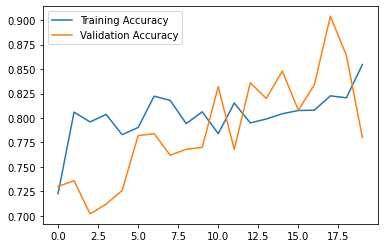

In [266]:
accuracy = [x / train_batch for x in total_correct]
val_accuracy = [x / test_batch for x in total_validation_correct]
plt.figure()
plt.plot(accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()

In [166]:
first_layer_kernels = np.random.randn(3,3)
second_layer_kernels = np.random.randn(3,3)
learning_rate = 0.0001

In [ ]:
# batch

first_layer_output = []
second_layer_output = []

first_relu_layer = []
second_relu_layer = []

first_norm_layer = []
second_norm_layer = []

dense_layer = []
soft_layer = []
der = []

input_gradient = []
kernel_der = []
der = []
weight_der = np.zeros((576,10))


index = 0
correct = 0
batch = 20

training_data = x_train_m[0:batch]

for i in range(batch):
  first_layer_output.append(signal.correlate2d(x_train_m[i], first_layer_kernels, "valid"))
  first_relu_layer.append(relu(first_layer_output[i]))
  first_norm_layer.append(normalize(first_relu_layer[i]))

  second_layer_output.append(signal.correlate2d(first_norm_layer[i], second_layer_kernels, "valid"))
  second_relu_layer.append(relu(second_layer_output[i]))
  second_norm_layer.append(normalize(second_relu_layer[i]))

  dense_layer.append(dense_layer2(second_norm_layer[i], 10))
  soft_layer.append(softmax(dense_layer[i]))
  der.append(soft_layer[i] - one_hot_encode[i])
  if soft_layer[i].argmax() == y_train_m[i]:
    correct += 1

final_der = np.zeros((10))
for i in range(batch):
  final_der += der[i]

array = np.array(second_norm_layer)
for i in range(batch):
  weight_der += np.dot(array[i].reshape(-1,1), final_der.reshape(1,-1))
weights -= learning_rate * weight_der

array = np.array(final_der)
input_derivatives = np.dot(weights, array.transpose())
reshaped_input_derivatives = input_derivatives.reshape(24,24)

array = np.array(first_norm_layer)

derivative_filters_current_layer, derivative_current_layer_input = backpropagation(reshaped_input_derivatives, array, second_layer_kernels)
second_layer_kernels -= learning_rate * derivative_filters_current_layer

array = np.array(first_norm_layer)
derivative_filters_current_layer, derivative_current_layer_input = backpropagation(derivative_current_layer_input, training_data, first_layer_kernels)
first_layer_kernels -= learning_rate * derivative_filters_current_layer